# Tutorial for Probabilistic Generative Models for Network Analysis (`pgm`)

Welcome to this tutorial on using the _Probabilistic Generative Models for Network Analysis_ (`pgm`) package. In this tutorial, we'll walk through the process of running the _CRep_ algorithm on a sample dataset.

## Package Structure
Before delving into the usage of the _CRep_ algorithm, let's explore the structure of the `pgm` package, which is organized into three main modules:

### 1. Input
The `input` module handles data input for subsequent use by the algorithms in the `model` module. It comprises the following submodules:  

- `loader`: Functions to load data from input files.  
- `preprocessing`: Functions for data preprocessing, such as converting NetworkX graphs to sparse adjacency matrices.  
- `tools`: Utility functions for working with matrices, tensors, and sparsity.  
- `statistics`: Functions for computing statistics on the data.  
- `generate_networks`: Functions for generating synthetic networks.  

In most cases where users have their own data, they typically use only the `loader` and `preprocessing` modules. The other modules serve as internal components supporting these primary functionalities. The `generate_networks` module is utilized when no data is available, and the user wants to generate synthetic networks.

### 2. Model
The `model` module encompasses the implementation of various algorithms, including the following submodules:  

- `CRep`: Implementation of the CRep algorithm.  
- `cv`: Implementation of the cross-validation algorithm.  
- `cv_CRep`: Cross-validation for the CRep algorithm.  

### 3. Output
The `output` module contains functions responsible for handling the outputs of the models. It consists of the following submodule:
 
- `evaluate`: Essential functions for model assessment, such as AUC for link prediction, conditional and marginal expectations, and the pseudo log-likelihood of the data.  

Having explored the package structure, let's see how to use it to run the _CRep_ algorithm.

## Configuration
Let's start by configuring the algorithm and the parameters needed. The pipeline works based on two types of parameters:
1. **Numerical parameters:** These are the parameters that are used by the algorithm to run. For example, the convergence tolerance, the number of iterations, the number of realizations, etc. These are set by default in the model's class definition, but they can be changed by the user.
2. **Model parameters:** These are the parameters that are used by the algorithm. For example, the number of communities _K_, the reciprocity coefficient _eta_, etc. These are set by the user in the configuration file corresponding to the used model. In the case of the _CRep_ algorithm, this file is `setting_CRep.yaml`.  
Notice that the data is not a parameter, but an input to the algorithm, hence, it is not included in the default configuration of the class nor in the configuration file.

In [5]:
import os

import numpy as np
import yaml

Let's start by loading the configuration file for the _CRep_ algorithm. This file is located in the `pgm/data/model` folder. 

In [6]:
# setting to run the algorithm
algorithm = 'CRep'
config_path = 'setting_' + algorithm + '.yaml'

We load the configuration file using the data files in the `pgm` package instead of a relative path to it:

In [7]:
import importlib.resources as res

with res.open_binary('pgm.data.model', config_path) as fp:
    conf = yaml.load(fp, Loader=yaml.Loader)

In [8]:
# Print the configuration file
print(yaml.dump(conf))

K: 3
assortative: true
constrained: true
end_file: _test
eta0: null
files: config/data/input/theta_gt111.npz
fix_eta: false
initialization: 0
out_folder: outputs/
out_inference: true
rseed: 0
undirected: false


The previous file shows the parameters actually needed to _run_ the model. These parameters set the algorithms basic needs to work.  

 

Now, let's change the path to the output folder, so we can save the results into the same folder where this notebook is. 

In [9]:
# Change the output folder
conf['out_folder'] = './' + algorithm + '_output/'

In [10]:
# Ensure the output folder exists
if not os.path.exists(conf['out_folder']):
    os.makedirs(conf['out_folder'])

Finally, let's save this configuration file to the output folder, so we can keep track of the parameters used to run the model.

In [11]:
# Save the configuration file
output_config_path = conf['out_folder'] + '/setting_' + algorithm + '.yaml'
with open(output_config_path, 'w') as f:
    yaml.dump(conf, f)

## Importing Data
Once the configuration file is set, we can import the data. 
Now, let's import the data using the `pgm` package:

In [12]:
from pgm.input.loader import import_data
from pathlib import Path

ego = 'source'
alter = 'target'
force_dense = False  # Sparse matrices
root_dir = Path.cwd().parent.parent.parent.resolve()
in_folder = root_dir / 'pgm/data/input/'
adj = Path('syn111.dat')
network = in_folder / adj  # network complete path

A, B, B_T, data_T_vals = import_data(network,
                                     ego=ego,
                                     alter=alter,
                                     force_dense=force_dense,
                                     header=0)

/home/dtheuerkauf/toolkit/prob-gen-model-for-nets/pgm/data/input/syn111.dat shape: (5512, 3)
Removing self loops
Number of nodes = 600
Number of layers = 1
Number of edges and average degree in each layer:
E[0] = 5512 - <k> = 18.373
M[0] = 5899 - <k_weighted> = 19.663
Reciprocity (networkX) = 0.423
Reciprocity (intended as the proportion of bi-directional edges over the unordered pairs) = 0.268
Reciprocity (considering the weights of the edges) = 0.515


The previous call to `import_data` loads the data from the input folder, and returns the following:

- `A`: A list of NetworkX graphs, where each graph represents a snapshot of the network.  
- `B`: A list of (sparse) adjacency matrices, where each matrix represents a snapshot of the network.   
- `B_T`: A list of (sparse) adjacency matrices, where each matrix represents a snapshot of the network, but with the rows and columns transposed.  
- `data_T_vals`: Array with values of entries `A[j, i]` given non-zero entry `(i, j)`.  

Notice that `A` is this time consisting of only one graph, since we are using a single network. However, the _CRep_ algorithm can handle multiple networks, and in that case `A` would be a list of graphs.

In [13]:
len(A)

1

The basic statistics related to the data have been shown after importing them. But if we are interested in seeing them again, we can compute them using the `statistics` module:

In [14]:
from pgm.input.statistics import print_graph_stat

rw = [0]
print_graph_stat(A, rw)

Number of nodes = 600
Number of layers = 1
Number of edges and average degree in each layer:
E[0] = 5512 - <k> = 18.373
M[0] = 5899 - <k_weighted> = 19.663
Reciprocity (networkX) = 0.423
Reciprocity (intended as the proportion of bi-directional edges over the unordered pairs) = 0.268
Reciprocity (considering the weights of the edges) = 0


The list `rw` consists of the reciprocity values of each of the graphs in the list `A`. Since we do not have this information yet, we can simply set it to zero. 

We can see now that the network has 600 nodes, 5512 edges, average degree of 18.3733, and reciprocity of 0.423. 

Let's take a look at the graph. Since it has a very large number of edges, we will show its adjacency matrix instead:

In [15]:
type(B)

sktensor.sptensor.sptensor

In [16]:
B_reshaped = B.toarray().reshape(B.shape[1], B.shape[2])

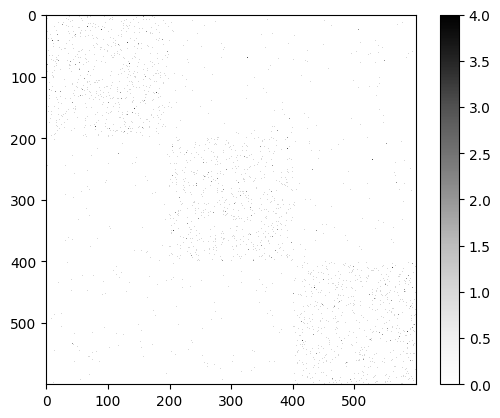

In [17]:
import matplotlib.pyplot as plt

plt.imshow(B_reshaped, cmap='Greys', interpolation='none')

# Add a color bar for reference
plt.colorbar()

plt.show()

## Running the Model
Finally, we are ready to run the _CRep_ model! The way this works is in a two-step process: first, we called the `CRep` class, which initializes the model. Then, we call the `fit` method, which runs the algorithm. 

In [18]:
from pgm.model.crep import CRep
import time

nodes = A[0].nodes()

model = CRep()

# Print all the attributes of the model
print(model.__dict__)

{'inf': 10000000000.0, 'err_max': 1e-12, 'err': 0.1, 'num_realizations': 5, 'convergence_tol': 0.0001, 'decision': 10, 'max_iter': 1000, 'verbose': True, 'flag_conv': 'log'}


Model created! Now, we can run the model using the `fit` method. As mentioned before, this method takes as input the data, and the configuration parameters.

In [19]:
print(f'\n### Run {algorithm} ###')
time_start = time.time()
_ = model.fit(data=B,
              data_T=B_T,
              data_T_vals=data_T_vals,
              nodes=nodes,
              **conf)

print(f'\nTime elapsed: {np.round(time.time() - time_start, 2)} seconds.')


### Run CRep ###
eta is initialized randomly.
u, v and w are initialized randomly.
Updating realization 0 ...
Nreal = 0 - Pseudo Log-likelihood = -20988.30573077476 - iterations = 100 - time = 0.28 seconds
Nreal = 0 - Pseudo Log-likelihood = -20926.578289217818 - iterations = 200 - time = 0.54 seconds
Nreal = 0 - Pseudo Log-likelihood = -20921.298815149363 - iterations = 300 - time = 0.8 seconds
Nreal = 0 - Pseudo Log-likelihood = -20918.29123068266 - iterations = 400 - time = 1.07 seconds
Nreal = 0 - Pseudo Log-likelihood = -20917.130041963468 - iterations = 500 - time = 1.33 seconds
Nreal = 0 - Pseudo Log-likelihood = -20916.836494211893 - iterations = 600 - time = 1.6 seconds
Nreal = 0 - Pseudo Log-likelihood = -20916.774912488054 - iterations = 700 - time = 1.86 seconds
Nreal = 0 - Pseudo Log-likelihood = -20916.774960752904 - iterations = 721 - time = 1.92 seconds

eta is initialized randomly.
u, v and w are initialized randomly.
Updating realization 1 ...
Nreal = 1 - Pseudo Log-

## Analyzing the results
Next, we will examine the outcomes produced by the model. To accomplish this, it is necessary to load the contents from the file `CRep_output/theta_CRep.npz.`

In [20]:
filename = Path('./CRep_output/theta_CRep.npz')
theta = np.load(filename)

Once this is done, we can unpack the latent variables as follows:

In [21]:
u, v, w, eta = theta['u'], theta['v'], theta['w'], theta['eta']

As outlined in [1], the variables _u_ and _v_ characterize the in-coming and out-going memberships of the nodes in the graph. In this specific demonstration, it's important to recall that we configured the model parameter _K_, representing the number of communities, to be 3. Consequently, by examining the values of _u_ for each node in _G_, we can ascertain the probability that the respective node belongs to either the first, second, or third community.

In [21]:
for idx, values in enumerate(u[:10]):  # Only for the 10 first nodes
    print(f'The probability that the node {idx} belongs to one of the communities is given as {values}')

The probability that the node 0 belongs to one of the communities is given as [0. 1. 0.]
The probability that the node 1 belongs to one of the communities is given as [0.         0.66586587 0.33413413]
The probability that the node 2 belongs to one of the communities is given as [0. 0. 1.]
The probability that the node 3 belongs to one of the communities is given as [0.18678271 0.81321729 0.        ]
The probability that the node 4 belongs to one of the communities is given as [0. 1. 0.]
The probability that the node 5 belongs to one of the communities is given as [0.         0.59552389 0.40447611]
The probability that the node 6 belongs to one of the communities is given as [0. 1. 0.]
The probability that the node 7 belongs to one of the communities is given as [0. 0. 1.]
The probability that the node 8 belongs to one of the communities is given as [0. 1. 0.]
The probability that the node 9 belongs to one of the communities is given as [0. 0. 1.]


For more details about the meaning of the latent variables, we refer the user to the publication [1]. 

### References

[1] Hadiseh Safdari, Martina Contisciani, Caterina De Bacco. “A generative model for reciprocity and community detection in networks.” _Phys. Rev. Research_ Vol 3, 023209, 2021.